<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png"/>

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>    

# Clasificación de textos con BiLSTM. 

En este notebook, vamos a desarrollar un enfoque basado en BiLSTM para clasificar las reviews de Amazon sobre Alexa. Este dataset puede descargarse desde este [link](#https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews) en Kaggle. 



## Dataset

In [24]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Colab Notebooks/data/alexa/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd

df = pd.read_csv(PATH+"amazon_alexa.tsv",  sep='\t', on_bad_lines='skip') 
print('dataset cargado:', df.shape)

# nos quedamos únicamente con el texto y el campo de rating
df = df[['verified_reviews','rating']] 
# renombramos las columnas
df=df.rename(columns={"verified_reviews": "Text", "rating": "Label"})
df.head()


dataset cargado: (3150, 5)


,Text,Label
0,Love my Echo!,5
1,Loved it!,5
2,"Sometimes while playing a game, you can answer...",4
3,I have had a lot of fun with this thing. My 4 ...,5
4,Music,5


### Particiones

El dataset se distribuye en un único fichero. Debemos crear tres particiones distintas para entrenamiento, validación y evaluación final (test), con un ratio de 70:10:20.



In [26]:
from sklearn.model_selection import train_test_split
X=df['Text']
y=df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X, y, 
        test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, 
        test_size=2/3, random_state=42, stratify=y_aux)

print('Tamaño conjunto de entrenamiento:', len(X_train))
print('Tamaño conjunto de validación:', len(X_val))
print('Tamaño conjunto de evaluación:', len(X_test))


Tamaño conjunto de entrenamiento: 2205
Tamaño conjunto de validación: 315
Tamaño conjunto de evaluación: 630


### Distribución de clases



Distribución en training: {5: 1600, 4: 319, 1: 113, 3: 106, 2: 67}
Distribución en validación: {5: 229, 4: 45, 1: 16, 3: 15, 2: 10}
Distribución en test: {5: 457, 4: 91, 1: 32, 3: 31, 2: 19}
dict_keys([5, 4, 1, 3, 2])


Text(0, 0.5, 'Número de Instancias')

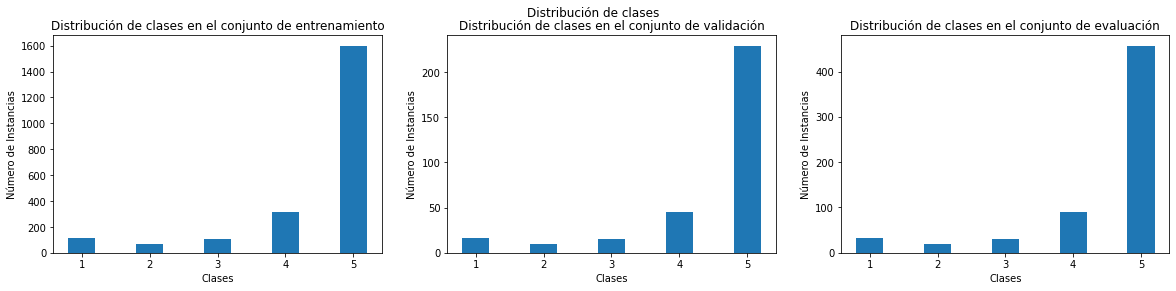

In [27]:
import matplotlib.pyplot as plt

counts_train = y_train.value_counts().to_dict()
print("Distribución en training:", counts_train)
counts_val = y_val.value_counts().to_dict()
print("Distribución en validación:", counts_val)
counts_test = y_test.value_counts().to_dict()
print("Distribución en test:", counts_test)

LABELS=counts_train.keys()
print(LABELS)


fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución de clases')
ax_train.bar(LABELS, counts_train.values(), width=0.4)
ax_train.set_title('Distribución de clases en el conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

ax_val.bar(LABELS, counts_val.values(), width=0.4)
ax_val.set_title('Distribución de clases en el conjunto de validación')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('Número de Instancias')


ax_test.bar(LABELS, counts_test.values(), width=0.4)
ax_test.set_title('Distribución de clases en el conjunto de evaluación')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

Podemos ver que las clases no están balanceadas, siendo la 5 (muy positivo) la de mayor número de instancias, y la 2 la de menor número de instancias.

### Distribución del tamaño de los textos


count    2205.000000
mean       26.170522
std        36.618675
min         0.000000
25%         6.000000
50%        15.000000
75%        32.000000
90%        60.000000
95%        86.800000
99%       171.000000
max       526.000000
Name: Text, dtype: float64


Text(0, 0.5, 'Número de textos')

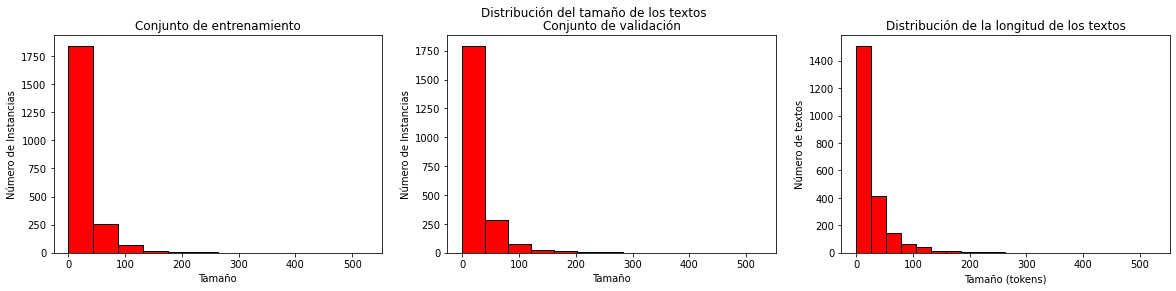

In [28]:
length_train=X_train.apply(lambda text: len(text.split()))
print(length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))
length_val=X_val.apply(lambda text: len(text.split()))
length_test=X_test.apply(lambda text: len(text.split()))

fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución del tamaño de los textos')

ax_train.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(600/50))
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Tamaño')
ax_train.set_ylabel('Número de Instancias')

ax_val.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(200/15))
ax_val.set_title('Conjunto de validación')
ax_val.set_xlabel('Tamaño')
ax_val.set_ylabel('Número de Instancias')

ax_test.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(300/15))
ax_test.set_title('Conjunto test')
ax_test.set_xlabel('Tamaño')
ax_test.set_ylabel('Número de Instancias')

# Add labels
plt.title('Distribución de la longitud de los textos')
plt.xlabel('Tamaño (tokens)')
plt.ylabel('Número de textos')

Gracias a los tres gráficos, podemos afirmar que la distribución de las clases es similar en los tres subconjuntos de datos. 
La mayoría de los textos tienen menos de 100 palabras.

## Label Encoding



In [29]:
LABELS = list(set(y_train))
print(LABELS)
NUM_LABELS = len(LABELS)


y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()


print(y_train[:10])

[1, 2, 3, 4, 5]
[5, 5, 5, 5, 5, 1, 5, 1, 2, 4]


## Codificación de etiquetas

In [30]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
# las clases pasan de ser 1,2,3,4,5 a 0,1,2,3,4
print("después de transform:", y_train[:10])
# cada clase se representa como un vector one-hot de dimension 5
y_train_cat = to_categorical(y_train)
# print(y_train_cat[:10])

y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)

print(y_test[:10])
y_test = le.fit_transform(y_test)
print(y_test[:10])

y_test_cat = to_categorical(y_test)


antes de transform:  [5, 5, 5, 5, 5, 1, 5, 1, 2, 4]
después de transform: [4 4 4 4 4 0 4 0 1 3]
[5, 5, 4, 5, 2, 5, 3, 4, 3, 5]
[4 4 3 4 1 4 2 3 2 4]


### Tokenización

Puedes consultar más información sobre el tokenizador de keras en este [link](#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).


In [31]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences 

tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

MAX_LEN= 100 # longitud de la secuencia
encoded_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_LEN, padding='post')


Tamaño del vocabulario =3740


## BiLSTM

In [33]:
import tensorflow as tf 
tf.random.set_seed(42) # para asegurar experimentos son reproducibles

tf.__version__

'2.9.2'

In [34]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

EMBEDDING_SIZE=200
DROPOUT=0.4

model = Sequential()
# capa donde se crea la matriz de word embeddings
# Cada token está asociado con un entero (gracias a la tokenización)
# Cada entero está asociado a un vector de la matriz
# Las secuencias se representan con estos vectores
model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))

model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)))
# Añadimos una capaz droput después de la capa bilstm 
model.add(Dropout(DROPOUT))

model.add(Bidirectional(LSTM(50, recurrent_dropout=0.2)))
model.add(Dropout(DROPOUT))

model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 200)          748000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 200)         240800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 100, 200)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 100)              100400    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)               

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Save the model after every epoch.
# saveBestModel = ModelCheckpoint(root+'CNNbest.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


### Training

In [ ]:
# Entrenamos el modelo
epochs = 10 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
# El tamaño del conjunto aprendizaje es 2205, 2205/16 = 138. 
# En cada epoch, entrenamos 138 veces y actualizamos
batch_size = 16 

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/20
138/138 [==============================] - 209s 1s/step - loss: 0.8974 - accuracy: 0.7206 - val_loss: 0.8140 - val_accuracy: 0.7048
Epoch 2/20
138/138 [==============================] - 173s 1s/step - loss: 0.7214 - accuracy: 0.7497 - val_loss: 0.7712 - val_accuracy: 0.7429
Epoch 3/20
138/138 [==============================] - 171s 1s/step - loss: 0.6305 - accuracy: 0.7696 - val_loss: 0.8142 - val_accuracy: 0.7302
Epoch 4/20
138/138 [==============================] - 170s 1s/step - loss: 0.5465 - accuracy: 0.7850 - val_loss: 0.7928 - val_accuracy: 0.7143
Epoch 5/20
138/138 [==============================] - 169s 1s/step - loss: 0.4764 - accuracy: 0.8200 - val_loss: 0.8972 - val_accuracy: 0.7302
Epoch 6/20
138/138 [==============================] - 170s 1s/step - loss: 0.4397 - accuracy: 0.8340 - val_loss: 0.7863 - val_accuracy: 0.7238
Epoch 7/20
138/138 [==============================] - 171s 1s/step - loss: 0.3898 - accuracy: 0.8494 - val_loss: 0.9166 - val_accuracy: 0.7333

### Curvas de aprendizaje

En las curva de aprenzije, el modelo es evaluado en el conjunto de entrenamiento para saber cómo de bien el modelo es capaz de aprender.
Además, el modelo también se evalúa en el conjunto de validación para saber cómo de bien el modelo es capaz de generalizar. 

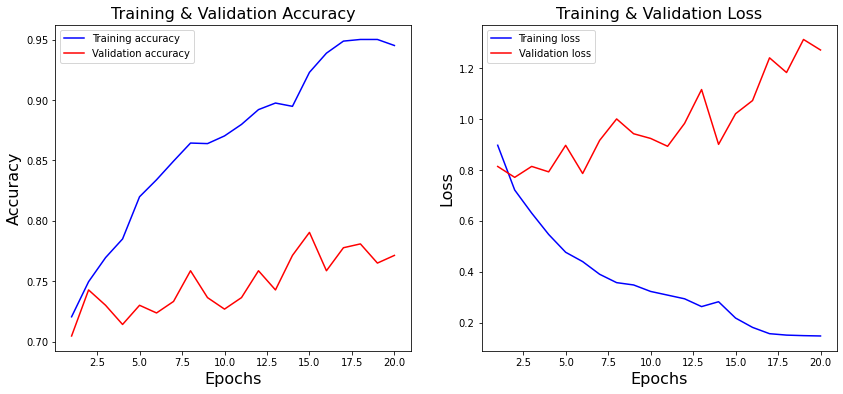

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

### Evaluación

In [ ]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)
# El tamaño del conjunto test es de 630
# SE evalua en batch de 16: 630 / 16 = 40 veces

40/40 [==============================] - 4s 93ms/step - loss: 1.2430 - accuracy: 0.7714


También podemos hacer la evaluación usando las función **classification_report** que nos dará más información sobre los resultados para cada clase:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report 

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print(y_pred[0:10])
print('accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['1','2','3','4','5']))

20/20 [==============================] - 3s 94ms/step
[3 4 3 4 0 3 3 3 2 3]
accuracy: 0.7714285714285715
              precision    recall  f1-score   support

           1       0.35      0.25      0.29        32
           2       0.67      0.32      0.43        19
           3       0.86      0.39      0.53        31
           4       0.50      0.59      0.54        91
           5       0.85      0.89      0.87       457

    accuracy                           0.77       630
   macro avg       0.64      0.49      0.53       630
weighted avg       0.77      0.77      0.76       630



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  8   2   1   3  18]
 [  5   6   1   1   6]
 [  4   1  12   3  11]
 [  3   0   0  54  34]
 [  3   0   0  48 406]]


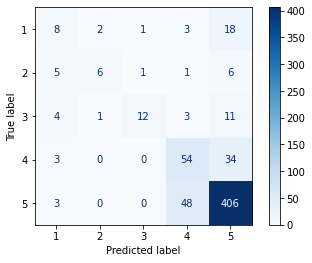

In [ ]:

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['1','2','3','4','5'])
disp.plot(cmap=plt.cm.Blues,values_format='g')


## Discusión
- ¿Qué enfoque obtiene mejores resultados: CNN o BiLSTM?
- Respecto a los resultados por clase, ¿qué clase obtiene mejores resultados?
- ¿Qué nos dice la matriz de confusion?